Здесь идет добавление всех нужных библиотек и команд

In [211]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
import numpy as np
import plotly.graph_objects as go

%matplotlib inline

В переменной filepath хранится путь до датасета. В переменной insurance_data хранится дата фрейм по нашему датасету

In [212]:
#Path of the file to read
filepath = "health_lifestyle_classification.csv"
#Read the file into a variable df
df = pd.read_csv(filepath)




В датасете более 100+ тысяч строк и 41 признак. Выберем необходимое и отсеем лишнее.

Целевым признаком для предсказания будет target (Бинарная классификация): healthy (здоров) / diseased (болен)

Из числовых признаков возьмём:
- age (Возраст)
- bmi (Индекс массы тела)
- blood pressure
- cholesterol
- glucose
- insulin
- calorie intake
- sugar intake
- water intake
- stress level
- heart rate
- sleep hours
- work hours
- daily steps

Из категориальных признаков возьмём:
- gender
- diet type
- sleep quality
- sunlight exposure
- caffeine intake
- exercise type
- meals per day
- alchohol consumption
- smoking level

Таким образом были убраны следующие признаки:
- screen time
- family history
- mental health score
- occupation
- mental health support
- device usage
- healthcare access
- insurance
- pet owner
- height
- weight
- waist size
- bmi ?*
- physical activity
- education level
- job type
- income
- electrolyte level
- gene marker flag
- enviromnent risk score
- daily supplement dosage


In [213]:
delete_columns = [
    'screen_time',
    'family_history',
    'mental_health_score',
    'occupation',
    'mental_health_support',
    'device_usage',
    'healthcare_access',
    'insurance',
    'pet_owner',
    'height',
    'weight',
    'waist_size',
    'bmi_estimated',
    'bmi_corrected',
    'bmi_scaled',
    'physical_activity',
    'education_level',
    'job_type',
    'income',
    'electrolyte_level',
    'gene_marker_flag',
    'environmental_risk_score',
    'daily_supplement_dosage',
    'survey_code'
]

for column in delete_columns:
    df = df.drop(column, axis=1)

Здесь происходит отчищение, то есть если столбец с числовыми значениями, то мы заменяем пропуски на медиану всего столбца. Если качественный значения - удаляем.

In [214]:
for column in df.columns:
    if (df[column].dtype == "int64" or df[column].dtype == "float64"):
        median = df[column].median()
        df[column] = df[column].fillna(median)
    else:
        df = df.dropna(subset=[column])

Функция для обнаружения выбросов

In [215]:
def outliers_indices(feature):
    mid = df[feature].mean()
    sigma = df[feature].std()
    return df[(df[feature] < mid - 3 * sigma) | (df[feature] > mid + 3*sigma)].index

Удаление выбросов и поиск их в числовых признаках.

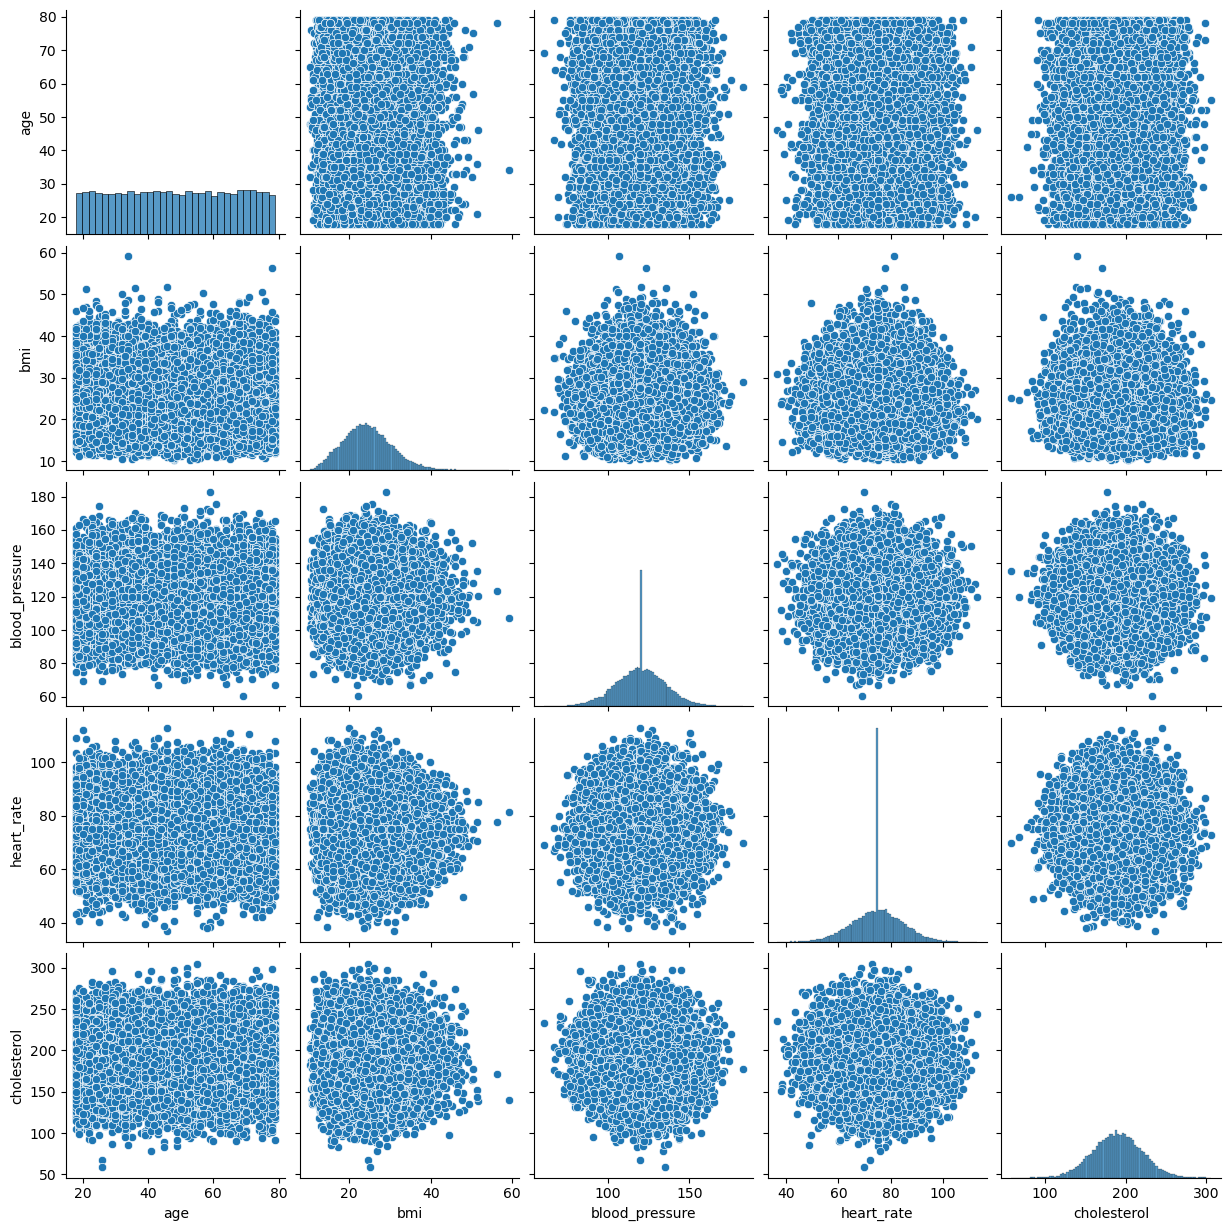

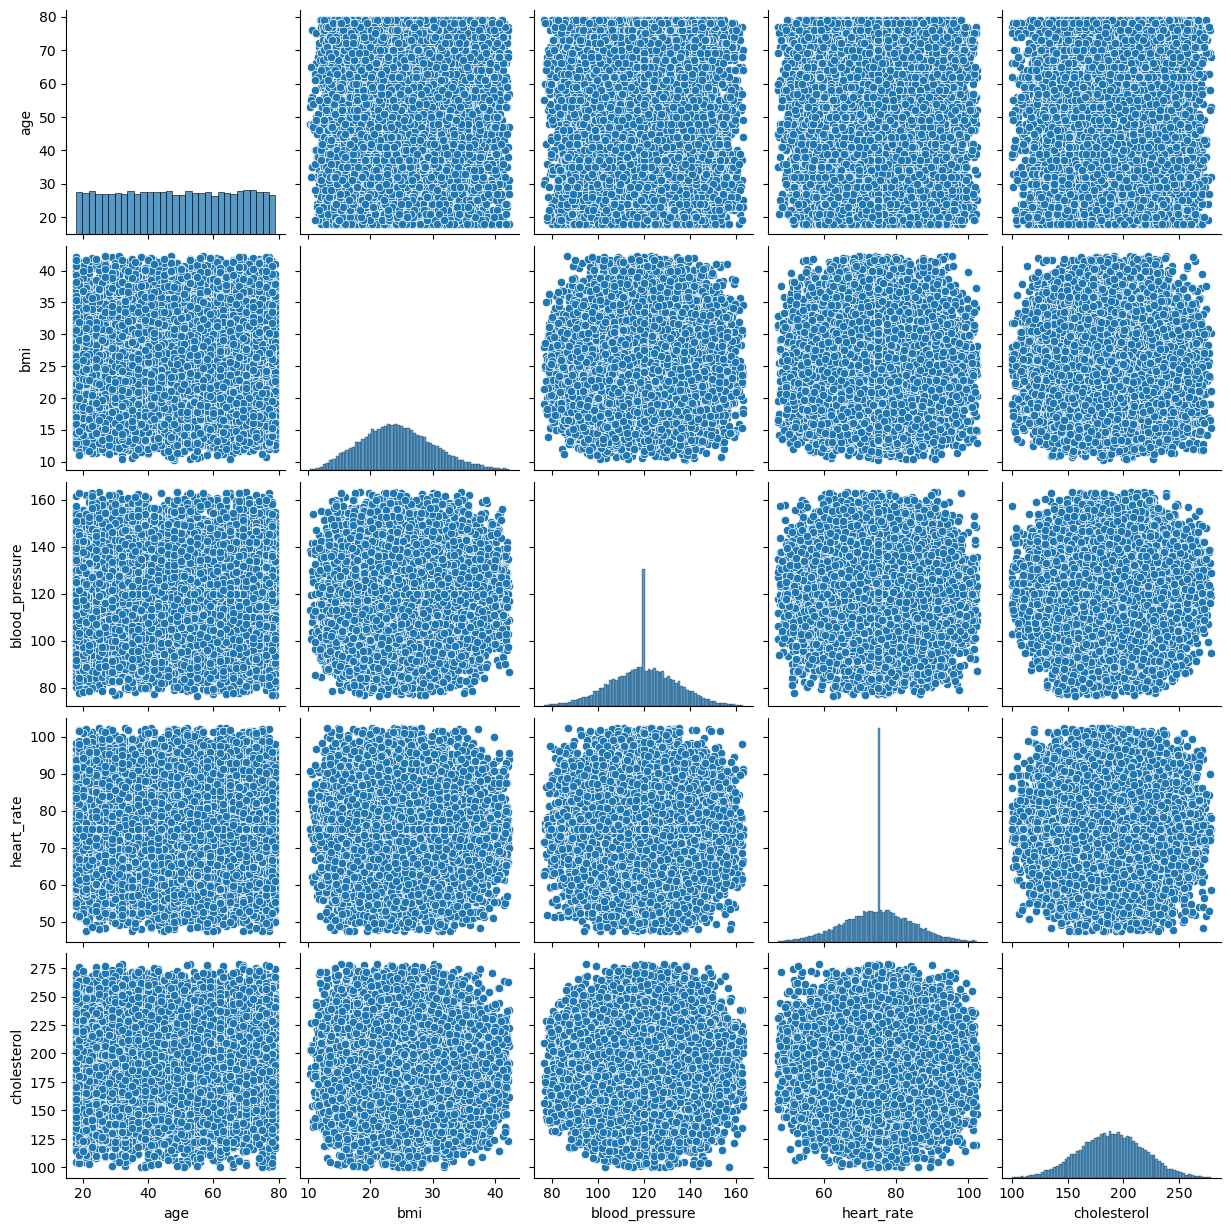

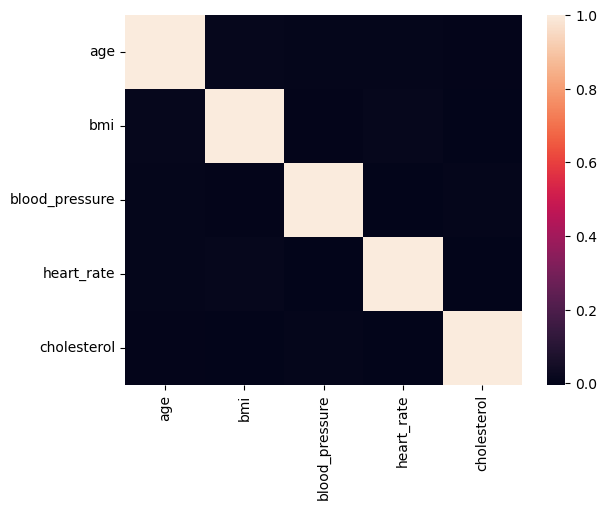

In [216]:
numeric = ['age', 'bmi', 'blood_pressure', 'heart_rate', 'cholesterol']
sns.pairplot(df[numeric])

out = set()
for i in range(len(numeric)):
        wrong_val = outliers_indices(numeric[i])
        out |= set(wrong_val)
df.drop(out, inplace=True)

sns.pairplot(df[numeric])
plt.show()
sns.heatmap(df[numeric].corr(method='spearman'))

plt.show()

Здесь соответсвенно идет нормализация всех данных в Data Frame, числовые - с помощью Max и Min, а качественные через предыдущую функцию

In [217]:
#Normalization of Data Frame
age_min = df['age'].min()
age_max = df['age'].max()
bp_min = df['blood_pressure'].min()
bp_max = df['blood_pressure'].max()
vspan_min_normalized = (60 - age_min)/(age_max - age_min)
vspan_max_normalized = (100 - age_min)/(age_max - age_min)
hspan_min_normalized = (140 - bp_min)/(bp_max - bp_min)
hspan_max_normalized = (200 - bp_min)/(bp_max - bp_min)

scaler = preprocessing.MinMaxScaler()
numeric_columns = df.select_dtypes(include=['int64', 'float64']).columns
df[numeric_columns] = scaler.fit_transform(df[numeric_columns])
object_columns = df.select_dtypes(include=["object"]).columns
for column in object_columns:
        one_hot = pd.get_dummies(df[column], prefix=column)
        df = df.drop(column, axis=1)
        df = pd.concat([df, one_hot], axis=1)

Удаляем дубликаты

In [218]:
#Delete dublicates
#insurance_data_unique = insurance_data.drop_duplicates()
df = df.drop_duplicates()
print(df['target_diseased'])

1        False
2        False
10       False
16       False
17       False
         ...  
99987    False
99989    False
99994    False
99998    False
99999     True
Name: target_diseased, Length: 28405, dtype: bool


Строим диаграмму рассеивания

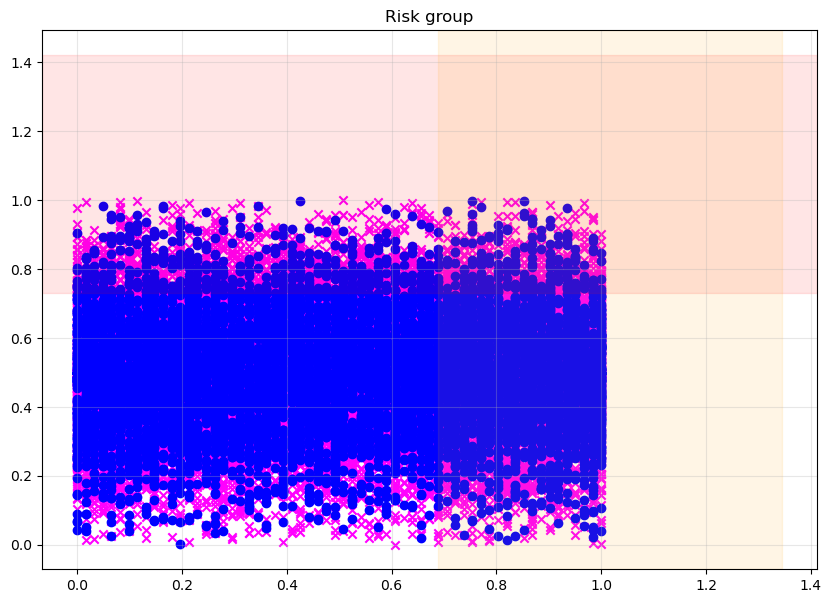

In [219]:

plt.figure(figsize=(10, 7))
plt.scatter('age', 'blood_pressure', data=df[df['target_healthy'] == 1], marker='x', c='magenta')
plt.scatter('age', 'blood_pressure', data=df[df['target_diseased'] == 1], marker='o', c = 'blue')
plt.title("Risk group")
plt.grid(True, alpha=0.3)
plt.axhspan(hspan_min_normalized, hspan_max_normalized, alpha=0.1, color='red', label="High BloodPressure zone")
plt.axvspan(vspan_min_normalized, vspan_max_normalized, alpha=0.1, color='orange', label="Elderly zone")
plt.show()

Строим ящики с усами для некоторых численных столбцов

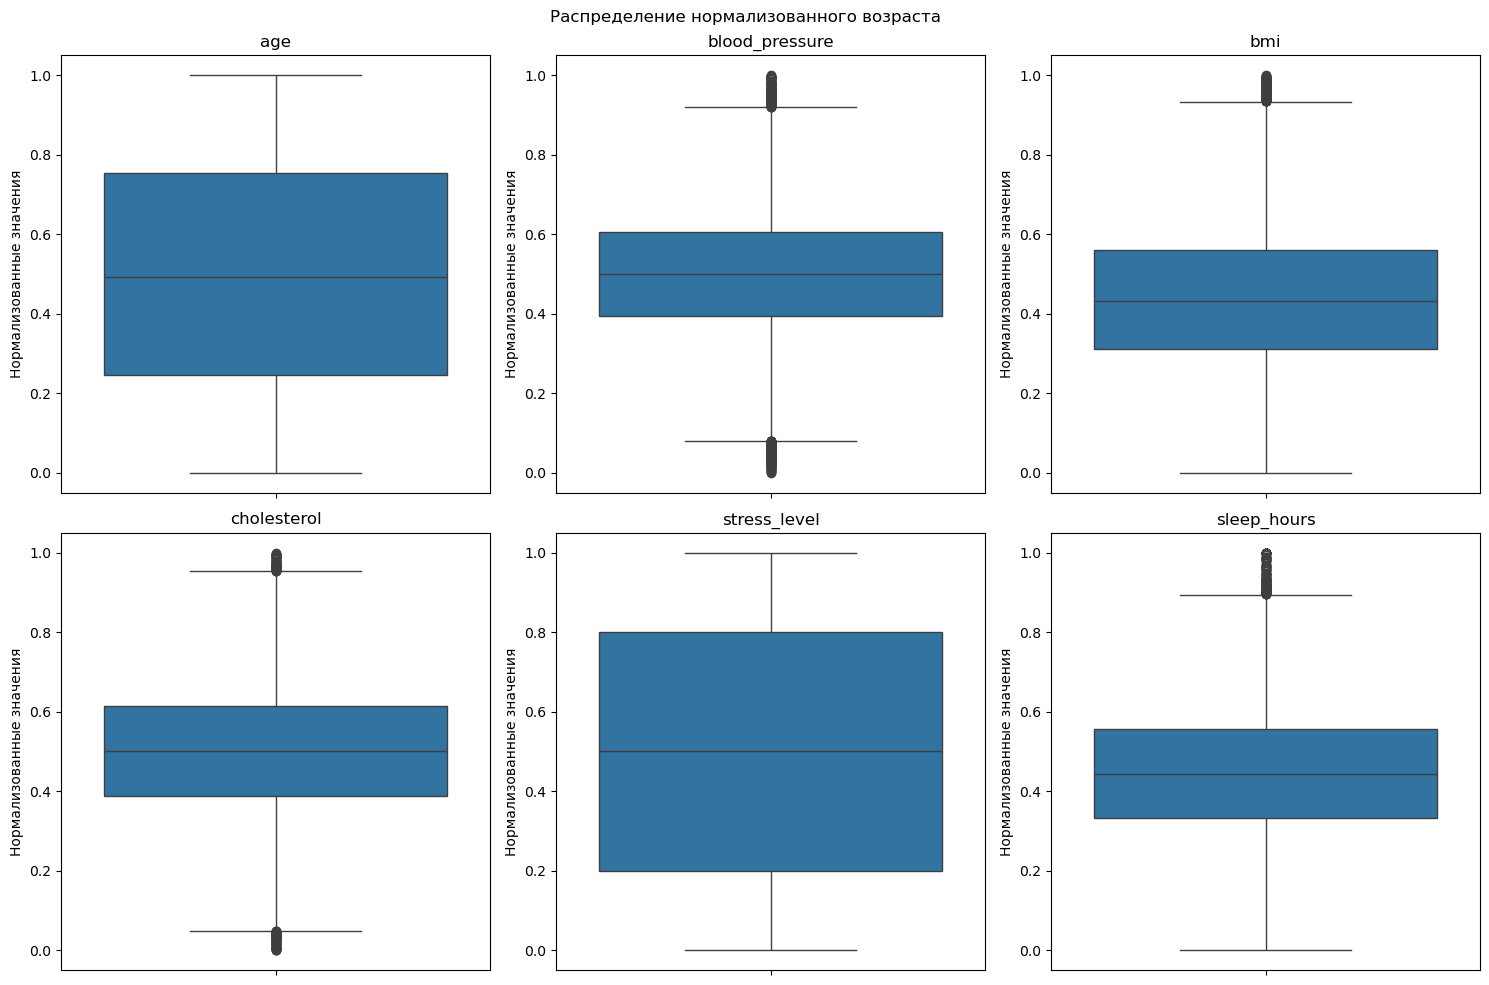

In [220]:
features = ['age', 'blood_pressure', 'bmi', 'cholesterol', 'stress_level', 'sleep_hours']
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
fig.suptitle('Распределение нормализованного возраста')

for i, feature in enumerate(features):
    row = i //3
    col = i % 3
    sns.boxplot(y=df[feature], ax=axes[row, col])
    axes[row, col].set_title(feature)
    axes[row, col].set_ylabel('Нормализованные значения')

plt.tight_layout()
plt.show()

Гистограммы для тех же признаков

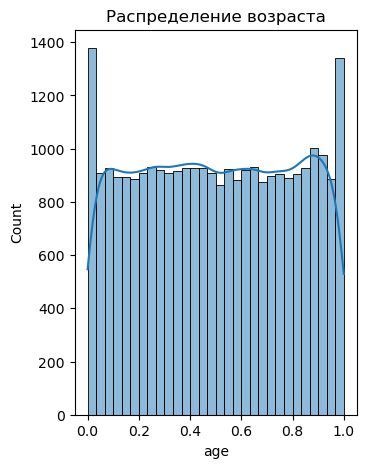

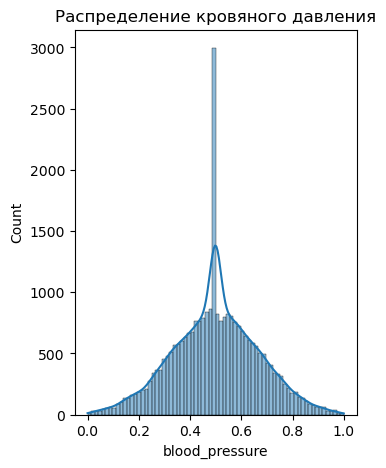

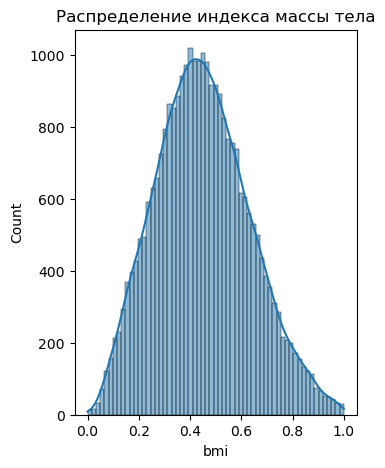

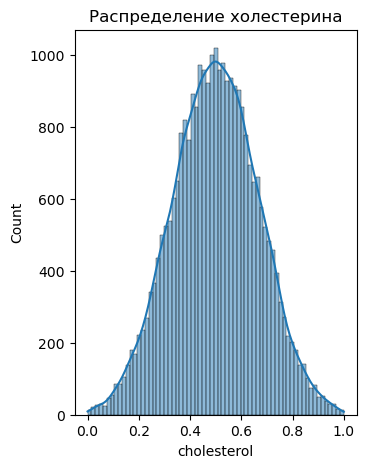

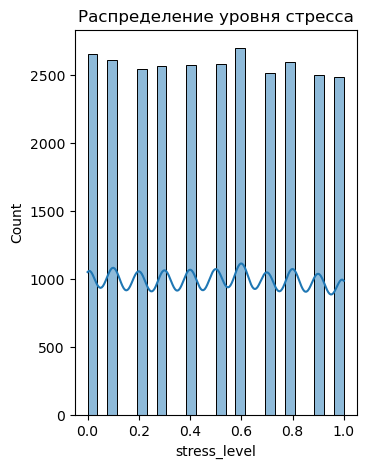

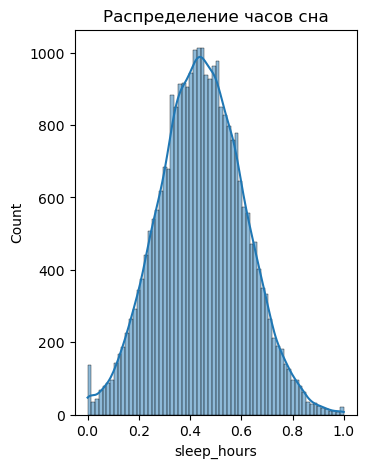

In [204]:
plt.figure(figsize=(8, 5))
plt.subplot(1, 2, 1)
sns.histplot(df['age'], kde=True)
plt.title('Распределение возраста')

plt.figure(figsize=(8, 5))
plt.subplot(1, 2, 1)
sns.histplot(df['blood_pressure'], kde=True)
plt.title('Распределение кровяного давления')

plt.figure(figsize=(8, 5))
plt.subplot(1, 2, 1)
sns.histplot(df['bmi'], kde=True)
plt.title('Распределение индекса массы тела')

plt.figure(figsize=(8, 5))
plt.subplot(1, 2, 1)
sns.histplot(df['cholesterol'], kde=True)
plt.title('Распределение холестерина')

plt.figure(figsize=(8, 5))
plt.subplot(1, 2, 1)
sns.histplot(df['stress_level'], kde=True)
plt.title("Распределение уровня стресса")

plt.figure(figsize=(8, 5))
plt.subplot(1, 2, 1)
sns.histplot(df['sleep_hours'], kde=True)
plt.title("Распределение часов сна")
plt.show()